In [242]:
import heapq
from sklearn.datasets import make_blobs
import math
# !pip install numpy matplotlib scikit-learn networkx

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
import networkx as nx


class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point
        self.axis = axis
        self.left = left
        self.right = right


class KDTree:
    def __init__(self):
        self.root = None

    def build(self, points, depth=0):
        if not points:
            return None

        k = len(points[0])
        axis = depth % k

        points.sort(key=lambda x: x[axis])
        median = len(points) // 2

        return KDNode(
            point=points[median],
            axis=axis,
            left=self.build(points[:median], depth + 1),
            right=self.build(points[median + 1 :], depth + 1),
        )

    def insert(self, point):
        def _insert_rec(node, point, depth=0):
            if node is None:
                k = len(point)
                return KDNode(point, depth % k)

            if point[node.axis] < node.point[node.axis]:
                node.left = _insert_rec(node.left, point, depth + 1)
            else:
                node.right = _insert_rec(node.right, point, depth + 1)

            return node

        self.root = _insert_rec(self.root, point)


def i_neighbors(tree, query_point, i):
    if tree.root is None:
        return None
    i += 1
    neighbors = []
    visited = set()

    def _search(node):
        if node is None or node in visited:
            return

        visited.add(node)

        distance = sum([(a - b) ** 2 for a, b in zip(node.point, query_point)]) ** 0.5

        if len(neighbors) < i:
            heapq.heappush(neighbors, (-distance, node.point))
        else:
            if distance < -neighbors[0][0]:
                heapq.heappop(neighbors)
                heapq.heappush(neighbors, (-distance, node.point))

        axis = node.axis
        next_branch = node.left if query_point[axis] < node.point[axis] else node.right
        opposite_branch = (
            node.right if query_point[axis] < node.point[axis] else node.left
        )

        _search(next_branch)

        if (
            len(neighbors) < i
            or abs(query_point[axis] - node.point[axis]) < -neighbors[0][0]
        ):
            _search(opposite_branch)

    _search(tree.root)
    neighbors.sort(key=lambda x: -x[0])
    neighbors = [(-d, p) for d, p in neighbors]
    return neighbors[1 : i + 1]


def brute_force_neighbors(points, query_point, i):
    distances = []
    for point in points:
        distance = sum([(a - b) ** 2 for a, b in zip(point, query_point)]) ** 0.5
        distances.append((distance, point))
    distances.sort(key=lambda x: x[0])
    return distances[1 : i + 1]


def verify_kd_tree(tree, points, query_point, i):
    kd_neighbors = i_neighbors(tree, query_point, i)
    bf_neighbors = brute_force_neighbors(points, query_point, i)

    kd_points = [p for _, p in kd_neighbors]
    bf_points = [p for _, p in bf_neighbors]

    return kd_points == bf_points


if __name__ == "__main__":
    points, _ = make_blobs(n_samples=10, centers=3, n_features=3, random_state=42)
    points = points.tolist()

    tree = KDTree()
    tree.root = tree.build(points)

    query_point = [1, 2, 3]
    i = 2

    neighbors = i_neighbors(tree, query_point, i)
    print("i-th nearest neighbors from KD-Tree:", neighbors)

    is_correct = verify_kd_tree(tree, points, query_point, i)
    print("Verification result:", is_correct)

i-th nearest neighbors from KD-Tree: [(6.763035758175511, [-3.433280460799855, 6.40173711550472, 5.590248518625004]), (7.6258688305368505, [-3.2516044601719227, 8.310942326490915, 2.500258180151862])]
Verification result: True


In [243]:
def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

In [244]:
def plot_3d_graph(G):
    pos = nx.get_node_attributes(G, "pos")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x, y, z, color="b")

    xs = [pos[key][0] for key in pos]
    ys = [pos[key][1] for key in pos]
    zs = [pos[key][2] for key in pos]
    ax.scatter(xs, ys, zs, c="r", marker="o")

    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    plt.title("3D NetworkX Graph")
    plt.show()

In [245]:
def round_coordinates(points, decimals=1):
    return [tuple(round(coord, decimals) for coord in point) for point in points]

In [246]:
# Install dependencies (uncomment and run in a terminal or notebook cell)

# Generate 3D points with 3 clusters
n_samples = 50
n_features = 3
n_clusters = 1

X, y = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
)

points = [tuple(point) for point in X.tolist()]
points = round_coordinates(points, decimals=1)
maxdis = math.ceil(math.log2(len(points)))

In [247]:
def build():
    tree = KDTree()

    tree.root = tree.build(points)

    # NetworkX graph construction
    G = nx.Graph()
    for point in points:
        G.add_node(tuple(point), pos=tuple(point))

    neighbours = {}
    
    for point in points:
        neighbours[point] = i_neighbors(tree, point, maxdis)
    return G, neighbours

50 0
Connected Components :  50
The graph has 50 nodes and 0 edges.
Adding edge between (-4.6, 8.4, 5.2) and (-4.0, 8.2, 5.4) with weight 0.66332495807108
Adding edge between (-4.5, 8.1, 6.0) and (-4.0, 8.2, 5.4) with weight 0.7874007874011808
Adding edge between (-4.1, 9.8, 4.1) and (-3.4, 9.6, 4.5) with weight 0.8306623862918077
Adding edge between (-4.0, 8.2, 5.4) and (-3.7, 8.2, 5.4) with weight 0.2999999999999998
Adding edge between (-3.9, 8.1, 3.5) and (-2.9, 8.3, 3.9) with weight 1.0954451150103324
Adding edge between (-3.7, 8.2, 5.4) and (-4.0, 8.2, 5.4) with weight 0.2999999999999998
Adding edge between (-3.6, 9.3, 4.9) and (-3.4, 9.6, 4.5) with weight 0.5385164807134502
Adding edge between (-3.5, 8.9, 5.6) and (-3.2, 9.0, 5.1) with weight 0.5916079783099615
Adding edge between (-3.5, 9.1, 4.2) and (-3.4, 9.6, 4.5) with weight 0.5916079783099616
Adding edge between (-3.4, 9.6, 4.5) and (-3.4, 9.8, 4.9) with weight 0.4472135954999587
Adding edge between (-3.4, 9.8, 4.9) and (-3

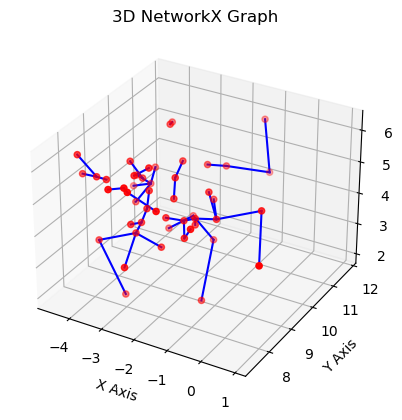

Connected Components :  10
The graph has 50 nodes and 40 edges.
Adding edge between (-3.7, 8.2, 5.4) and (-3.0, 8.4, 5.6) with weight 0.7549834435270752
Adding edge between (-3.5, 8.9, 5.6) and (-3.0, 8.4, 5.6) with weight 0.7071067811865476
Adding edge between (-2.7, 8.6, 5.1) and (-3.0, 8.4, 5.6) with weight 0.6164414002968973
Adding edge between (-2.2, 8.4, 3.6) and (-2.2, 8.6, 4.4) with weight 0.8246211251235323
Adding edge between (-3.0, 9.9, 6.3) and (-2.4, 9.6, 5.5) with weight 1.044030650891055
Adding edge between (-3.3, 10.4, 6.0) and (-3.4, 9.8, 4.9) with weight 1.2569805089976531
Adding edge between (-1.9, 7.8, 5.2) and (-1.1, 8.1, 4.7) with weight 0.9899494936611662
Adding edge between (-3.0, 8.4, 5.6) and (-2.7, 8.6, 5.1) with weight 0.6164414002968973
Adding edge between (-2.7, 8.6, 5.8) and (-2.7, 8.6, 5.1) with weight 0.7000000000000002
Adding edge between (-2.7, 9.4, 3.4) and (-2.2, 8.4, 3.6) with weight 1.1357816691600546
Adding edge between (-1.2, 8.7, 2.0) and (-2.2

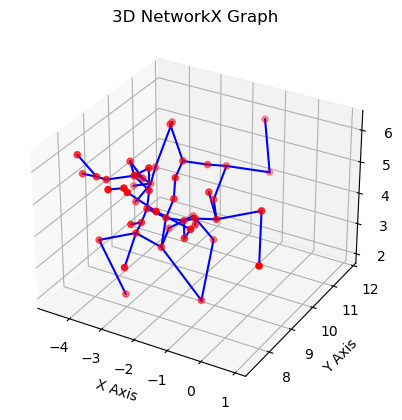

Connected Components :  1
50 54


In [248]:
G, neighbours = build()
print(G.number_of_nodes(), G.number_of_edges())
k = 0
while k < maxdis:

    print("Connected Components : ", len(list(nx.connected_components(G))))
    if (len(connected_components := list(nx.connected_components(G)))) == 1:
        break
    print(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
        )
    for component in connected_components:
        for node in component:
            wt, pos = neighbours[node][k]
            if pos in component:
                continue
            print(f"Adding edge between {node} and {pos} with weight {wt}")
            G.add_edge(node, pos, weight=wt)
    k += 1
    plot_3d_graph(G)
print(G.number_of_nodes(), G.number_of_edges())

In [249]:
neighbours

{(-4.6, 8.4, 5.2): [(0.66332495807108, (-4.0, 8.2, 5.4)),
  (0.8602325267042626, (-4.5, 8.1, 6.0)),
  (0.9433981132056601, (-3.7, 8.2, 5.4)),
  (1.272792206135785, (-3.5, 8.9, 5.6)),
  (1.3784048752090219, (-3.6, 9.3, 4.9)),
  (1.5264337522473743, (-3.2, 9.0, 5.1))],
 (-4.5, 8.1, 6.0): [(0.7874007874011808, (-4.0, 8.2, 5.4)),
  (0.8602325267042626, (-4.6, 8.4, 5.2)),
  (1.0049875621120885, (-3.7, 8.2, 5.4)),
  (1.3416407864998743, (-3.5, 8.9, 5.6)),
  (1.552417469626002, (-3.1, 7.5, 5.7)),
  (1.5811388300841898, (-3.0, 8.4, 5.6))],
 (-4.1, 9.8, 4.1): [(0.8306623862918077, (-3.4, 9.6, 4.5)),
  (0.927361849549571, (-3.5, 9.1, 4.2)),
  (1.0630145812734653, (-3.4, 9.8, 4.9)),
  (1.0677078252031313, (-3.6, 9.3, 4.9)),
  (1.5652475842498528, (-3.2, 9.0, 5.1)),
  (1.6155494421403507, (-2.7, 9.4, 3.4))],
 (-4.0, 8.2, 5.4): [(0.2999999999999998, (-3.7, 8.2, 5.4)),
  (0.66332495807108, (-4.6, 8.4, 5.2)),
  (0.7874007874011808, (-4.5, 8.1, 6.0)),
  (0.8831760866327854, (-3.5, 8.9, 5.6)),
  (1.039

50 49


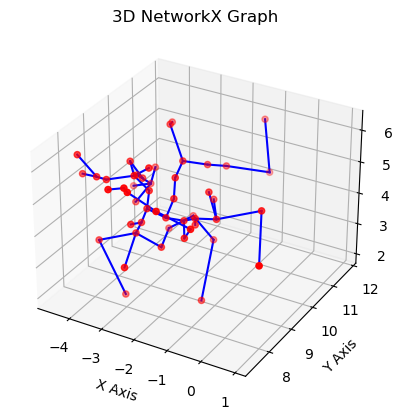

In [250]:
mst = nx.minimum_spanning_tree(G)
print(mst.number_of_nodes(), mst.number_of_edges())
plot_3d_graph(mst)

In [251]:
for node, attr in G.nodes(data=True):
    print(f"Point: {node}, Position: {attr['pos']}")

Point: (-4.6, 8.4, 5.2), Position: (-4.6, 8.4, 5.2)
Point: (-4.5, 8.1, 6.0), Position: (-4.5, 8.1, 6.0)
Point: (-4.1, 9.8, 4.1), Position: (-4.1, 9.8, 4.1)
Point: (-4.0, 8.2, 5.4), Position: (-4.0, 8.2, 5.4)
Point: (-3.9, 8.1, 3.5), Position: (-3.9, 8.1, 3.5)
Point: (-3.7, 8.2, 5.4), Position: (-3.7, 8.2, 5.4)
Point: (-3.6, 9.3, 4.9), Position: (-3.6, 9.3, 4.9)
Point: (-3.5, 8.9, 5.6), Position: (-3.5, 8.9, 5.6)
Point: (-3.5, 9.1, 4.2), Position: (-3.5, 9.1, 4.2)
Point: (-3.4, 9.6, 4.5), Position: (-3.4, 9.6, 4.5)
Point: (-3.4, 9.8, 4.9), Position: (-3.4, 9.8, 4.9)
Point: (-3.3, 10.4, 6.0), Position: (-3.3, 10.4, 6.0)
Point: (-3.2, 9.0, 5.1), Position: (-3.2, 9.0, 5.1)
Point: (-3.1, 7.5, 5.7), Position: (-3.1, 7.5, 5.7)
Point: (-3.1, 8.1, 2.0), Position: (-3.1, 8.1, 2.0)
Point: (-3.0, 9.9, 6.3), Position: (-3.0, 9.9, 6.3)
Point: (-3.0, 8.4, 5.6), Position: (-3.0, 8.4, 5.6)
Point: (-2.9, 8.3, 3.9), Position: (-2.9, 8.3, 3.9)
Point: (-2.9, 8.1, 4.3), Position: (-2.9, 8.1, 4.3)
Point: (-2

In [252]:
total_weight = 0
print("\nEdges in the MST and their weights (calculated manually):")
for edge in mst.edges():
    point1, point2 = edge
    weight = euclidean_distance(point1, point2)
    print(f"Edge: {point1} - {point2}, Weight: {weight}")
    total_weight += weight

print(f"\nTotal weight of the Minimum Spanning Tree: {total_weight}")


Edges in the MST and their weights (calculated manually):
Edge: (-4.6, 8.4, 5.2) - (-4.0, 8.2, 5.4), Weight: 0.66332495807108
Edge: (-4.5, 8.1, 6.0) - (-4.0, 8.2, 5.4), Weight: 0.7874007874011808
Edge: (-4.1, 9.8, 4.1) - (-3.4, 9.6, 4.5), Weight: 0.8306623862918077
Edge: (-4.0, 8.2, 5.4) - (-3.7, 8.2, 5.4), Weight: 0.2999999999999998
Edge: (-3.9, 8.1, 3.5) - (-2.9, 8.3, 3.9), Weight: 1.0954451150103324
Edge: (-3.9, 8.1, 3.5) - (-3.1, 8.1, 2.0), Weight: 1.7
Edge: (-3.7, 8.2, 5.4) - (-3.0, 8.4, 5.6), Weight: 0.7549834435270752
Edge: (-3.6, 9.3, 4.9) - (-3.4, 9.6, 4.5), Weight: 0.5385164807134502
Edge: (-3.6, 9.3, 4.9) - (-3.2, 9.0, 5.1), Weight: 0.5385164807134505
Edge: (-3.5, 8.9, 5.6) - (-3.2, 9.0, 5.1), Weight: 0.5916079783099615
Edge: (-3.5, 8.9, 5.6) - (-3.0, 8.4, 5.6), Weight: 0.7071067811865476
Edge: (-3.5, 9.1, 4.2) - (-3.4, 9.6, 4.5), Weight: 0.5916079783099616
Edge: (-3.4, 9.6, 4.5) - (-3.4, 9.8, 4.9), Weight: 0.4472135954999587
Edge: (-3.3, 10.4, 6.0) - (-3.0, 9.9, 6.3), Weig

In [253]:
complete_graph = nx.Graph()
for point in points:
    complete_graph.add_node(point, pos=point)

# Add edges with Euclidean distance as weights
for i, point1 in enumerate(points):
    for j, point2 in enumerate(points):
        if i != j:
            distance = euclidean_distance(point1, point2)
            complete_graph.add_edge(point1, point2, weight=distance)

# Print points and their positions
print("Points and their positions in the graph:")
for node, attr in complete_graph.nodes(data=True):
    print(f"Point: {node}, Position: {attr['pos']}")

# Calculate the MST using NetworkX's minimum_spanning_tree function
mst_graph = nx.minimum_spanning_tree(complete_graph)

# Calculate the total weight of the MST
total_weight = 0
print("\nEdges in the MST and their weights:")
for edge in mst_graph.edges(data=True):
    print(f"Edge: {edge[0]} - {edge[1]}, Weight: {edge[2]['weight']}")
    total_weight += edge[2]["weight"]

print(f"\nTotal weight of the Minimum Spanning Tree: {total_weight}")

Points and their positions in the graph:
Point: (-4.6, 8.4, 5.2), Position: (-4.6, 8.4, 5.2)
Point: (-4.5, 8.1, 6.0), Position: (-4.5, 8.1, 6.0)
Point: (-4.1, 9.8, 4.1), Position: (-4.1, 9.8, 4.1)
Point: (-4.0, 8.2, 5.4), Position: (-4.0, 8.2, 5.4)
Point: (-3.9, 8.1, 3.5), Position: (-3.9, 8.1, 3.5)
Point: (-3.7, 8.2, 5.4), Position: (-3.7, 8.2, 5.4)
Point: (-3.6, 9.3, 4.9), Position: (-3.6, 9.3, 4.9)
Point: (-3.5, 8.9, 5.6), Position: (-3.5, 8.9, 5.6)
Point: (-3.5, 9.1, 4.2), Position: (-3.5, 9.1, 4.2)
Point: (-3.4, 9.6, 4.5), Position: (-3.4, 9.6, 4.5)
Point: (-3.4, 9.8, 4.9), Position: (-3.4, 9.8, 4.9)
Point: (-3.3, 10.4, 6.0), Position: (-3.3, 10.4, 6.0)
Point: (-3.2, 9.0, 5.1), Position: (-3.2, 9.0, 5.1)
Point: (-3.1, 7.5, 5.7), Position: (-3.1, 7.5, 5.7)
Point: (-3.1, 8.1, 2.0), Position: (-3.1, 8.1, 2.0)
Point: (-3.0, 9.9, 6.3), Position: (-3.0, 9.9, 6.3)
Point: (-3.0, 8.4, 5.6), Position: (-3.0, 8.4, 5.6)
Point: (-2.9, 8.3, 3.9), Position: (-2.9, 8.3, 3.9)
Point: (-2.9, 8.1, 4.